In [12]:
import pandas as pd
import numpy as np
import shap
from floridaman import data_cleaning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [13]:
# load in data
raw_data = data_cleaning.load('null_transformed')

In [14]:
full_data = data_cleaning.drop_columns(raw_data, .4, .4)
balanced_data = data_cleaning.balance(full_data)

full_data = data_cleaning.impute_values(full_data, 5)
balanced_data = data_cleaning.impute_values(balanced_data, 5)

X_train = np.array(balanced_data[data_cleaning.features(balanced_data)])
y_train = np.array(balanced_data['FAILURETYPE'])

X_test = np.array(full_data[data_cleaning.features(full_data)])
y_test = np.array(full_data['FAILURETYPE'])

### Optimize Random Forest through Random Search

In [15]:
# Specify hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 4, stop = 10, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [16]:
# Create the hyperparameter grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [17]:
# Create a basic RF classifier
rf_model = RandomForestClassifier()

# Create grid search object with specified parameter grid. Perform 
# cross validation with 8 folds to randomly select combinations of hyperparameters 
# from random_grid and return the combination that performs the best.
rf_grid = GridSearchCV(estimator = rf_model, param_grid = random_grid, cv = 8, verbose = 2, n_jobs = -1)
# LOL n_jobs = 12 for the 14 core machine - please change this to something reasonable like 4

# Fit classifier to X_train and y_train
rf_grid.fit(X_train, y_train)

Fitting 8 folds for each of 4320 candidates, totalling 34560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2004 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 5244 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 7352 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 12536 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 15612 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 19016 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 22740 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 26792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 31164 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 34533 out 

GridSearchCV(cv=8, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [4, 4, 5, 6, 6, 7, 8, 8, 9, 10]},
             verbose=2)

In [18]:
# Create better model with tuned hyperparameters
best_model = rf_grid.best_estimator_

### Random Forest Results

In [19]:
print(str(classification_report(y_test, best_model.predict(X_test))))
print("")
print("Classifier training score: " + str(best_model.score(X_train, y_train)))
print("Best combination of hyperparameters: ")
rf_grid.best_params_ # prints the best combination of hyperparameters for our data set 

                 precision    recall  f1-score   support

           Rods       0.33      0.84      0.47       207
Sucker Rod Pump       0.66      0.63      0.65       590
         Tubing       0.79      0.53      0.64       874

       accuracy                           0.61      1671
      macro avg       0.60      0.67      0.59      1671
   weighted avg       0.69      0.61      0.62      1671


Classifier training score: 0.9677938808373591
Best combination of hyperparameters: 


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 8}

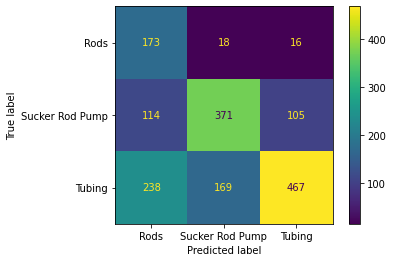

In [20]:
# Plot the confusion matrix
cm = plot_confusion_matrix(best_model, X_test, y_test)

# SHAP 

In [10]:
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

#### class # as we encoded it:
- Rods = 0
- SRP = 1
- Tubing = 2

### Explaining the prediction of one rod

In [1]:
shap.initjs()
# for sucker rod pumps prediction
shap.force_plot(explainer.expected_value[1], # row of expected_value for one rod (baseline prediction)
                shap_values[1][5], # shap values for class of SRP (class = 1) for that one rod
                X_test[5], # row of data for one rod
                feature_names = data_cleaning.features(X_train),
                matplotlib=False)
# prediction of 0.97 is probability that this rod had a SRP failure

NameError: name 'shap' is not defined

In [ ]:
shap.decision_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values[1][5],
    features=X_test[5],
    feature_names= data_cleaning.features(train_data),
)

### Summary for one class (SRP) and all features

In [ ]:
shap.summary_plot(shap_values = shap_values[1], # shap values for SRP class
                  features = X_test, 
                  max_display=20, # only displays 20 features
                  feature_names = data_cleaning.features(train_data),
                  plot_type='dot')
# this summary plot displays how each feature affects the magnitude of the 
# probability of our model classifying a rod as SRP 
# ex: AVG_WATER_VOL causes the probability of SRP failure
# to increase when it is at lower values

In [ ]:
shap.summary_plot(shap_values = shap_values[2], # shap values for SRP class
                  features = X_test, 
                  max_display=20, # only displays 20 features
                  feature_names = data_cleaning.features(train_data),
                  plot_type='bar')
# this summary plot displays how each feature overall affected the 
# probability of our model classifying a rod as SRP 
# ex: AVG_WATER_VOL mostly caused the probability of a rod to fail by SRP 
# to change the most (it had the most effect on classification of SRP)
# Wherever there is a mixed bag of dots, we know that there is a lot of 
# interaction effects with other features in making the decision for the model.

shap.dependence_plot("Feature 20", # affect of avg water volume on entire data set
                     shap_values=shap_values[1], 
                     features=X_test)

### Explain predictions for multiple rods in a single plot

In [ ]:
# still focuses on SRP class but includes ALL rods
shap.force_plot(explainer.expected_value[1], 
                shap_values[1], 
                X_test, 
                feature_names = data_cleaning.features(train_data),
                matplotlib=False)

CODE FROM BEFORE:

In [ ]:
#shap.summary_plot(shap_values, X_test, feature_names = data_cleaning.features(train_data), class_names = ['Rods', 'Sucker Rod Pump', 'Tubing'], show=False)
#plt.savefig('summaryPlot.png')

In [ ]:
#shap.save_html('RandomShap.html',shap.force_plot(explainer.expected_value[1], shap_values[1],
    # X_test, feature_names = data_cleaning.features(train_data),matplotlib=False))